In [1]:
import numpy as np
import collections
import os
import pickle

import gym

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()
print(env.observation_space)

print(gym.spaces.discrete)

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

Box(0, 255, (210, 160, 3), uint8)
<module 'gym.spaces.discrete' from '/home/lsi/anaconda3/lib/python3.8/site-packages/gym/spaces/discrete.py'>
States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [3]:
class MyDict:

    def __init__(self):
        self.map = dict()

    def value(self, key):
        try:
            k = self.map[key]
        except KeyError:
            k = np.random.random()-0.5
            self.map[key] = k
        return k

    def update(self, value):
        self.map.update(value)
        
    def delete(self, value):
        self.map.pop(value, 0)

    def len(self):
        return len(self.map)


In [4]:
import collections
import time

class Pong():
    
    UP = 2
    DOWN = 3

    def __init__(self, filename):
        self.lr = 0.8 # learning rate
        self.gamma = 0.99 # параметр дисконтирования
        self.env = gym.make('Pong-v0')
        self.filename = filename
        if self.filename is not None and os.path.isfile(self.filename):
            self.states = pickle.load(open(self.filename, 'rb'))
        else:
            self.states = MyDict()
        self.RewardPos = []
        self.discont = np.zeros(1000)
        self.discont[1000-1] = 1
        for i in reversed(range(1000-1)):
            self.discont[i] = self.discont[i+1] * self.gamma

    def ModifyImg(self, s0):
        # обрезка игрового поля
        s1 = s0[34:-16, 16:-16]
        s1 = s1[::2,::2,0]
        s1[s1 == 144] = 0
        s1[s1 == 109] = 0
        s1[s1 != 0] = 1
        return np.array(s1.ravel(), dtype=np.int8)


    def getaction(self, q):
        a = self.DOWN if q < 0 else self.UP
        return a


    def updategradient(self, value, act, r, ps):
        l = len(act)
        d = self.discont[-l:] * r
        for i in range(l):
            val = value[i]
            if act[i] == self.UP:
                value[i] += d[i]
            else:
                value[i] -= d[i]
            if r == -1:
                if val * value[i] < 0:
                    self.states.delete(ps[i])
        return value

        value[a == self.UP] += r # вверх
        value[a == self.DOWN] -= r # вниз
        return value


    def Diagram(self):
        fig, ax = plt.subplots()
        ax.plot(self.RewardPos[-1000:])
        plt.show()
        return None

    def fit(self, x):

        s0 = self.env.reset()
        prev_s = None
        ps, pa, pq = [], [], []
    
        for i in range(x):

            start_time = time.time()

            cpos, steps = 0, 0

            while True:

                steps += 1

                cur_s = self.ModifyImg(s0)
                s = hash(tuple(cur_s - prev_s if prev_s is not None else np.zeros(80*64)))
                prev_s = cur_s

                # выбор действия
                q = self.states.value(s)
                a = self.getaction(q)
                s0, r, done, _ = self.env.step(a)

                ps.append(s)
                pa.append(a)
                pq.append(q)
        
                if r:
                    pq = np.array(pq)
                    pa = np.array(pa)
                    res = self.updategradient(pq, pa, r, ps)
                    result = dict(zip(ps, res))
                    self.states.update(result)
                    ps, pa, pq = [], [], []
                #if r == -1:
                #    for s in ps:
                #        self.states.delete(s)
                #    ps, pa, pq = [], [], []
        
                cpos += r

                if done:
                    print("%d %d %d %3d %.3f" % (i, steps, self.states.len(), cpos, (time.time() - start_time)))
                    s0 = self.env.reset()
                    prev_s = None
                    break

            self.RewardPos.append(cpos)
        

            if i > 0 and i % 100 == 0:
                if self.filename is not None:
                    pickle.dump(self.states, open(self.filename, 'wb'))
                self.Diagram()
        
    def States(self):
        return self.states


0 2016 3668844 -18 1.884
1 1627 3669250 -20 1.501
2 1302 3669459 -20 1.188
3 2116 3670303 -18 1.916
4 1699 3670628 -17 1.536
5 1553 3670989 -20 1.407
6 1335 3671284 -21 1.219
7 1642 3671652 -18 1.482
8 1300 3671877 -20 1.172
9 1539 3672274 -20 1.382
10 1455 3672595 -20 1.304
11 1469 3672914 -20 1.301
12 1552 3673358 -20 1.375
13 1259 3673592 -21 1.128
14 1284 3673831 -21 1.136
15 1977 3674432 -18 1.754
16 1297 3674634 -20 1.191
17 1620 3675057 -20 1.519
18 1717 3675583 -20 1.525
19 1458 3675876 -20 1.299
20 1650 3676350 -21 1.474
21 1177 3676490 -21 1.057
22 1603 3676797 -17 1.424
23 1798 3677326 -18 1.599
24 1596 3677786 -19 1.413
25 1509 3678164 -21 1.351
26 1841 3678788 -19 1.634
27 2340 3679625 -15 2.087
28 1471 3680059 -20 1.345
29 1468 3680418 -20 1.314
30 1539 3680849 -20 1.383
31 1719 3681302 -20 1.546
32 1360 3681570 -21 1.218
33 1440 3681806 -19 1.279
34 1997 3682454 -19 1.781
35 2182 3683202 -15 1.991
36 1518 3683541 -21 1.375
37 1841 3684074 -19 1.656
38 1669 3684484 -19 1.

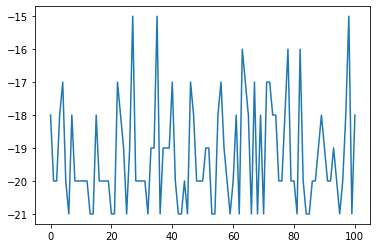

101 1437 3711484 -21 1.404
102 1101 3711590 -21 1.022
103 1249 3711811 -21 1.143
104 1548 3712159 -20 1.409
105 1929 3712839 -19 1.755
106 1951 3713388 -18 1.789
107 1258 3713564 -21 1.154
108 1536 3713954 -20 1.491
109 1673 3714339 -21 1.572
110 1847 3714963 -19 1.715
111 1228 3715155 -20 1.157
112 1738 3715596 -19 1.680
113 1348 3715769 -19 1.281
114 1509 3716088 -19 1.408
115 1349 3716329 -21 1.286
116 1552 3716719 -20 1.453
117 1326 3716917 -21 1.225
118 1836 3717482 -19 1.697
119 1439 3717867 -21 1.370
120 2068 3718510 -17 1.923
121 1635 3719032 -20 1.513
122 1702 3719530 -20 1.580
123 1581 3719883 -19 1.468
124 2113 3720692 -20 1.949
125 1187 3720833 -21 1.089
126 1320 3721098 -21 1.234
127 1167 3721238 -21 1.092
128 1430 3721580 -21 1.318
129 1639 3722048 -20 1.505
130 1701 3722577 -19 1.569
131 1724 3723070 -18 1.582
132 2314 3723834 -16 2.114
133 1577 3724242 -21 1.447
134 1804 3724747 -18 1.664
135 1397 3725034 -20 1.282
136 1617 3725596 -20 1.483
137 1335 3725831 -21 1.224
1

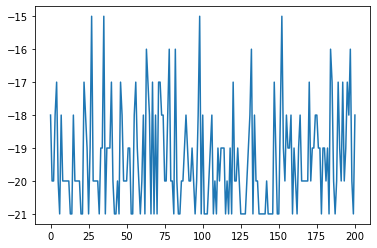

201 1115 3754560 -21 1.003
202 1998 3755206 -19 1.810
203 1809 3755770 -18 1.635
204 1862 3756285 -19 1.667
205 2084 3756984 -19 1.879
206 1467 3757352 -20 1.349
207 1462 3757588 -20 1.316
208 1724 3758012 -18 1.555
209 1936 3758491 -17 1.752
210 2138 3759076 -14 1.928
211 1667 3759550 -19 1.509
212 1943 3760318 -20 1.755
213 1542 3760742 -20 1.404
214 1470 3760994 -20 1.329
215 1751 3761498 -19 1.598
216 2082 3762233 -19 1.892
217 1898 3762757 -16 1.713
218 1844 3763314 -19 1.671
219 1840 3763927 -21 1.655
220 1553 3764354 -20 1.403
221 2007 3765078 -19 1.809
222 1796 3765529 -20 1.619
223 1772 3765988 -17 1.597
224 1610 3766526 -21 1.446
225 1616 3766927 -19 2.016
226 1641 3767355 -20 3.244
227 1570 3767727 -21 3.078
228 1099 3767809 -21 2.317
229 1676 3768177 -19 3.386
230 1595 3768494 -19 2.966
231 1432 3768746 -19 1.768
232 1717 3769186 -18 2.063
233 1603 3769590 -19 1.825
234 1275 3769793 -21 1.311
235 1972 3770313 -16 2.074
236 1605 3770685 -19 1.645
237 2068 3771293 -16 2.047
2

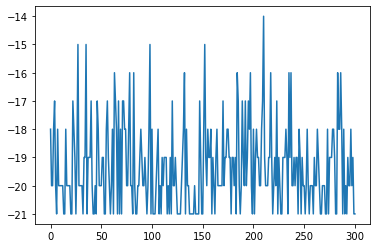

301 1340 3798612 -21 1.270
302 1891 3799086 -16 1.783
303 1782 3799597 -19 1.683
304 1173 3799743 -21 1.100
305 1772 3800263 -19 1.662
306 1394 3800536 -20 1.305
307 1588 3800866 -19 1.494
308 1630 3801254 -20 1.529
309 1927 3801837 -17 1.827
310 1380 3802099 -20 1.309
311 1459 3802450 -20 1.368
312 1401 3802685 -20 1.308
313 1237 3802825 -20 1.160
314 1414 3803107 -21 1.345
315 1526 3803405 -19 1.449
316 1631 3803780 -20 1.540
317 1359 3803917 -19 1.276
318 2072 3804640 -18 2.023
319 1924 3805274 -19 1.816
320 2056 3805890 -18 1.942
321 1469 3806231 -20 1.385
322 1540 3806692 -20 1.460
323 1880 3807239 -18 1.769
324 1716 3807622 -18 1.682
325 1943 3808323 -20 1.907
326 1401 3808632 -20 1.408
327 1335 3808880 -21 1.291
328 2001 3809474 -17 1.920
329 1567 3809833 -20 1.478
330 1962 3810471 -18 1.876
331 1824 3811086 -19 1.710
332 1901 3811745 -19 1.781
333 1873 3812233 -20 1.749
334 1419 3812493 -21 1.356
335 2912 3813556 -13 2.770
336 1471 3813911 -20 1.401
337 2073 3814547 -16 1.951
3

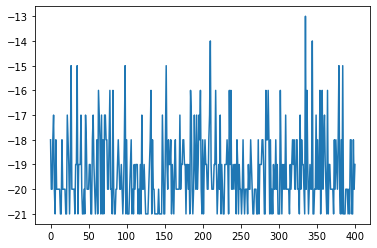

401 1670 3840268 -19 1.568
402 2376 3841286 -17 2.168
403 1510 3841529 -19 1.347
404 2509 3842449 -15 2.279
405 1710 3843022 -20 1.538
406 1789 3843566 -18 1.605
407 1104 3843614 -21 0.981
408 1427 3843949 -21 1.265
409 1686 3844332 -19 1.488
410 1482 3844684 -20 1.317
411 1351 3844897 -21 1.213
412 2166 3845699 -19 1.940
413 1560 3846019 -18 1.407
414 1774 3846637 -18 1.585
415 1338 3846878 -21 1.239
416 1633 3847287 -20 1.454
417 2294 3848276 -18 2.015
418 1758 3848722 -19 1.569
419 1865 3849307 -18 1.751
420 1966 3849962 -20 1.727
421 1526 3850319 -20 1.352
422 1093 3850407 -21 0.952
423 1838 3850990 -21 1.604
424 1616 3851280 -17 1.407
425 1383 3851565 -20 1.221
426 1252 3851794 -21 1.120
427 1833 3852287 -21 1.606
428 1906 3852903 -18 1.679
429 1544 3853302 -20 1.395
430 2031 3853930 -17 1.837
431 1847 3854530 -19 1.672
432 1664 3854980 -19 1.506
433 1980 3855600 -18 1.787
434 1427 3855942 -21 1.296
435 1890 3856505 -19 1.741
436 2090 3857225 -17 1.861
437 1846 3857663 -17 1.660
4

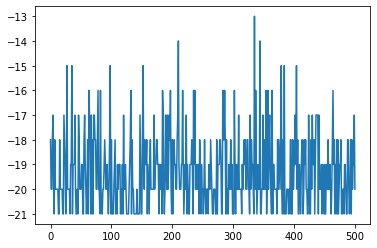

501 2106 3882699 -17 1.897


In [ ]:
import time

start_time = time.time()

p = Pong('pong0-r2.b')
p.fit(40000)

print("--- Total: %.3f seconds ---" % (time.time() - start_time))

In [5]:
if True: # Запустить этот блок нужно лишь один раз
  
    #!apt-get install -y xvfb python-opengl ffmpeg
    !pip install pyvirtualdisplay

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

EasyProcessError: start error <EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

In [6]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [8]:
from gym.wrappers import Monitor

env_sim = Monitor(env, './video', force=True)

s0 = env_sim.reset()
totalReward = 0
prev_s = None
states = p.States()

for _ in range(1000):
    env_sim.render()
    cur_s = p.ModifyImg(s0)
    s = tuple(cur_s - prev_s if prev_s is not None else np.zeros(60*60))
    prev_s = cur_s

    #a = env_sim.action_space.sample() # случайная стратегия
    a = np.argmax(states[s])
    s0, r, done, _ = env_sim.step(a+2)
#    steps.append(s)
    totalReward += r
    if r != 0:
        print('New reward = {}'.format(r))
    if done:        
        break
      
env_sim.close()

print('Total reward = {}'.format(totalReward))

New reward = -1.0
New reward = -1.0
New reward = 1.0
New reward = -1.0
New reward = -1.0
New reward = 1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
Total reward = -7.0


In [9]:
show_video()

video/openaigym.video.1.212606.video000000.mp4
